In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

In [2]:
G = 6.67*10**(-8) #cm^3/g/s^2
c = 3.0*10**10 #cm/s
msun = 1.99 * 10**33 #g
rsun = 6.95 * 10**10 #cm
sec_to_yr = 3.17098*10**(-8)
hubble_time =  14.4 * 10**9 #yr
AU_to_cm = 1.496*10**13 #cm

### The mass function of stars was first posited by Edwin Salpeter in 1955. While there are many updated models for the mass function, we use the Salpeter mass function for illustration purposes. The mass function $\xi(m)$ is given by $$\xi(m) \propto m^{-2.35}.$$ We will first draw samples from this mass function for the primary mass in the binary. We will assume that the minmum mass of stars under consideration is $20 M_\odot$ and maximum mass is $150 M_\odot$.

In [32]:
def gen_samples_using_invcdf(func, minimum, maximum, nsamples):
    """
    Implements inverse cdf sampling for a power function.
    
    """
    xarr = np.linspace(minimum, maximum, 50000)
    yarr = func(xarr)
    cumulative_sum = np.cumsum(yarr)
    cumulative_sum *= 1 / cumulative_sum[-1]
    
    interped_inverse_cdf = interp1d(cumulative_sum, xarr)    
    uniform_samples = np.random.uniform(min(cumulative_sum), 1, nsamples)
    
    return interped_inverse_cdf(uniform_samples)

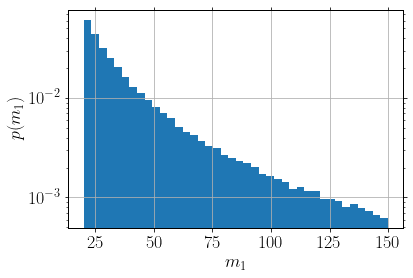

In [33]:
NSAMPLES = 100000
primary_mass = gen_samples_using_invcdf(lambda x: x**(-2.35), 20, 150, NSAMPLES)
m = np.linspace(8, 150, 100)
plt.hist(primary_mass, density=True, bins=40)
plt.xlabel("$m_1$")
plt.ylabel(r"$p(m_1)$")
plt.yscale("log")
plt.show()

### Now we assume that the distribution of mass ratio $q=m_2/m_1$ (ie. smaller mass divided by larger mass) is uniform. That is, $p(q) = \mathrm{constant}$, with limits 0.25 to 1.

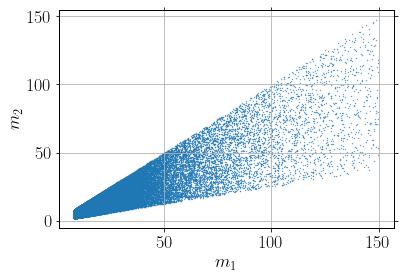

In [5]:
mass_ratio = np.random.uniform(0.25, 1, NSAMPLES)
secondary_mass = mass_ratio * primary_mass
plt.scatter(primary_mass, secondary_mass, s=0.1)
plt.xlabel(r"$m_1$")
plt.ylabel(r"$m_2$")
plt.show()

### We will now calculate the remnant mass by assuming $$M_\mathrm{remnant} = M_\mathrm{initial}^{0.75}$$. This power-law prescription is rather heuristic, and you can try to play around by changing the power law exponent.

In [51]:
def remnant_mass(M):
    M_remnant = (M) ** (0.75)
    return M_remnant

In [52]:
primary_remnant_mass = remnant_mass(primary_mass)
secondary_remnant_mass = remnant_mass(secondary_mass)

### Opik's law models the distribution of initial separation $a$  as $\frac{dP}{da} \propto 1/a $ ie. $\frac{dP}{d(\log a)} \propto 1$. Hence, this corresponds to sampling $a$ from a logUniform distribution. We will use the upper and lower limits as $10 R_\odot$ and $10^5 R_\odot$.

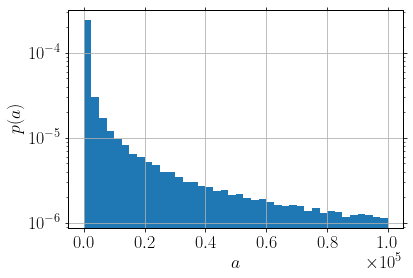

In [53]:
separation = stats.loguniform.rvs(a=10, b=1e5, size=NSAMPLES)
plt.hist(separation, density=True, bins=40)
plt.yscale("log")
plt.xlabel("$a$")
plt.ylabel(r"$p(a)$")
plt.show()

### We now have all the prescription to calculate the time delay. We will use some functions that we wrote on day 1.

In [54]:
def lifetime_beta(m1,m2):
    m1 = m1*msun
    m2 = m2*msun
    beta=(64./5.)*((G**3)*m1*m2*(m1+m2))/c**5
    return beta

def lifetime_funcof_a0_in_yrs(m1,m2,a0): #input: a0 in cm
    tc = a0**4./(4.*lifetime_beta(m1,m2))
    return tc*sec_to_yr                  #output: lifetime in years



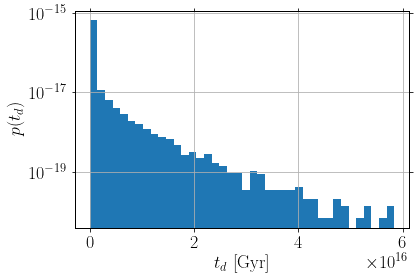

In [59]:
time_delays = lifetime_funcof_a0_in_yrs(primary_remnant_mass,
                                        secondary_remnant_mass,
                                        separation * rsun)
plt.hist(time_delays/1e9, density=True, bins=40)
plt.yscale("log")
plt.xlabel("$t_d$ [Gyr]")
plt.ylabel(r"$p(t_d)$")
plt.show()

### Some of the time delays are really large, let's restrict only to samples that have time delays less than Hubble time, ie 13.7e9 yrs.

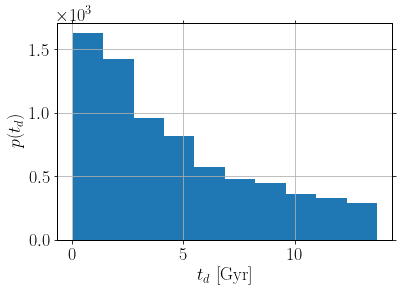

In [60]:
plt.hist(time_delays[time_delays / 1e9 < 13.7]/1e9)
plt.xlabel("$t_d$ [Gyr]")
plt.ylabel(r"$p(t_d)$")
plt.show()

In [63]:
print(min(time_delays) / 1e9, 100 * len(time_delays[time_delays / 1e9 < 10])/ len(time_delays))

0.027515279216283585 6.438
